# Predicting Low-Income Households in Selected Areas

This project aims to develop predictive models to estimate the number of low-income households in selected areas of Australia using Australian Bureau of Statistics (ABS) census data. These models will provide valuable insights for policymakers, urban planners, and social services to better understand and address socioeconomic challenges.

### Project Objectives

- Develop accurate predictive models for estimating the number of low-income households in selected areas.
- Identify key socioeconomic factors that contribute to the prevalence of low-income households.
- Create visualizations and reports to communicate findings effectively.
- Provide a tool for stakeholders to make data-driven decisions in policy and resource allocation.

### Project Scope

- Focus on predicting low-income households at the Statistical Area Level 2 (SA2) geographic level.
- Utilize ABS census data from the past census period (2021) for model development and validation.
- [WIP] Develop models for all of Australia, with the capability to focus on specific states or regions as needed.

### Data Sources

After consulting the Metadata table from General Community Profiles (GCP) of the Australian Census of 2021, 5 datasets were identified to be relevant to the project:
- Selected Medians and Averages - G02
- Total Household Income (Weekly) by Household Composition - G33
- Number of Motor Vehicles by Dwellings - G34
- Household Composition by Number of Persons Usually Resident - G35
- Mortgage Repayment (Monthly) by Dwelling Structure - G38

In [1]:
# Import packagaes
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import requests
from sasctl import Session
from sasctl.services import model_repository as mr, model_management as mm

In [2]:
# Import data

# Call csv file by name
g02 = pd.read_csv("./2021 Census GCP Statistical Area 2 for AUS/2021Census_G02_AUST_SA2.csv")
g33 = pd.read_csv("./2021 Census GCP Statistical Area 2 for AUS/2021Census_G33_AUST_SA2.csv")
g34 = pd.read_csv("./2021 Census GCP Statistical Area 2 for AUS/2021Census_G34_AUST_SA2.csv")
g35 = pd.read_csv("./2021 Census GCP Statistical Area 2 for AUS/2021Census_G35_AUST_SA2.csv")
g38 = pd.read_csv("./2021 Census GCP Statistical Area 2 for AUS/2021Census_G38_AUST_SA2.csv")

# Store DataFrames in a dictionary
gcp = {
    'g02': g02,
    'g33': g33,
    'g34': g34,
    'g35': g35,
    'g38': g38
}

## Exploratory Data Analysis

Exploratory data analysis (EDA) is crucial in data science projects because it helps us understand the structure and characteristics of the data we're working with. By exploring variables, identifying patterns, detecting anomalies, and visualizing relationships, EDA enables us to make informed decisions about data preprocessing, feature engineering, and model selection. It also plays a key role in uncovering insights and formulating hypotheses, laying the groundwork for more accurate modeling and impactful conclusions.

### Dataset Characteristics

In [3]:
# Function for dataset characteristics
def shape_column(df_name, df):
    # Show dimension and column names of our data
    shape_info = f"DataFrame Name: {df_name}\nShape: {df.shape}\nColumn names: {df.columns.tolist()}\n"
    return print(shape_info)

In [4]:
for df_name, df in gcp.items():
    shape_column(df_name, df)

DataFrame Name: g02
Shape: (2472, 9)
Column names: ['SA2_CODE_2021', 'Median_age_persons', 'Median_mortgage_repay_monthly', 'Median_tot_prsnl_inc_weekly', 'Median_rent_weekly', 'Median_tot_fam_inc_weekly', 'Average_num_psns_per_bedroom', 'Median_tot_hhd_inc_weekly', 'Average_household_size']

DataFrame Name: g33
Shape: (2472, 61)
Column names: ['SA2_CODE_2021', 'Neg_Nil_inc_fam_households', 'Neg_Nil_inc_Non_fam_househlds', 'Negative_Nil_income_Tot', 'HI_1_149_Family_households', 'HI_1_149_Non_family_hseholds', 'HI_1_149_Tot', 'HI_150_299_Family_households', 'HI_150_299_Non_fam_househlds', 'HI_150_299_Tot', 'HI_300_399_Family_households', 'HI_300_399_Non_fam_househlds', 'HI_300_399_Tot', 'HI_400_499_Family_households', 'HI_400_499_Non_fam_househlds', 'HI_400_499_Tot', 'HI_500_649_Family_households', 'HI_500_649_Non_fam_househlds', 'HI_500_649_Tot', 'HI_650_799_Family_households', 'HI_650_799_Non_fam_househlds', 'HI_650_799_Tot', 'HI_800_999_Fam_households', 'HI_800_999_Non_fam_hsehlds',

### Visualisations

Dive into each dataset to see what reationships and insight they hold.

#### Selected Medians and Averages - G02

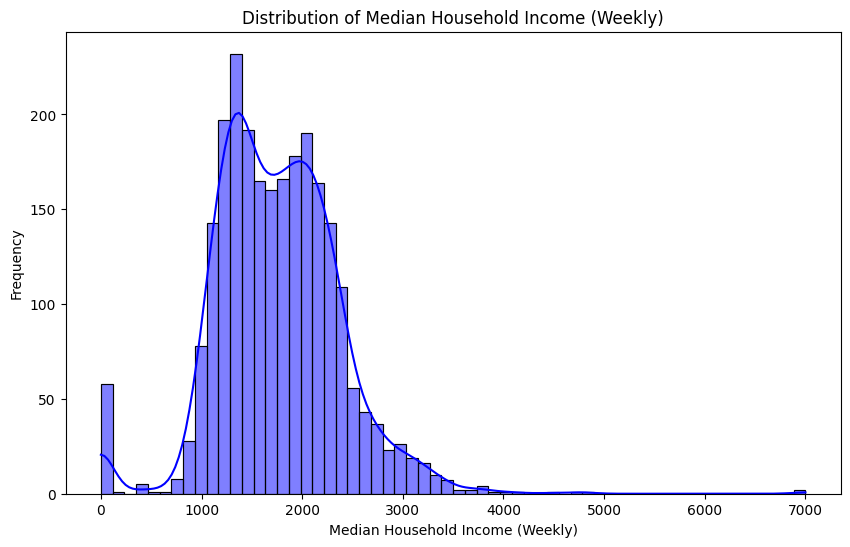

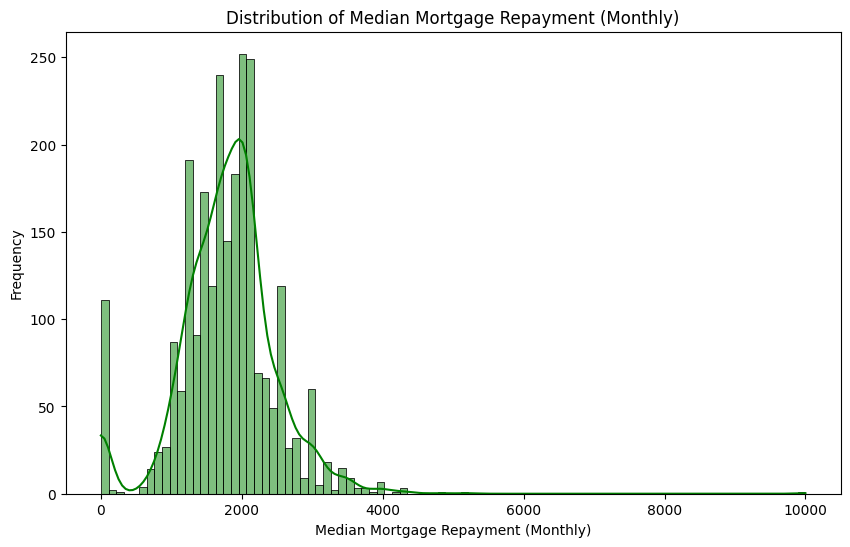

In [5]:
# Distribution of Median Household Income
plt.figure(figsize=(10, 6))
sns.histplot(g02['Median_tot_hhd_inc_weekly'], kde=True, color='blue')
plt.title('Distribution of Median Household Income (Weekly)')
plt.xlabel('Median Household Income (Weekly)')
plt.ylabel('Frequency')
plt.show()

# Distribution of Median Mortgage Repayment
plt.figure(figsize=(10, 6))
sns.histplot(g02['Median_mortgage_repay_monthly'], kde=True, color='green')
plt.title('Distribution of Median Mortgage Repayment (Monthly)')
plt.xlabel('Median Mortgage Repayment (Monthly)')
plt.ylabel('Frequency')
plt.show()


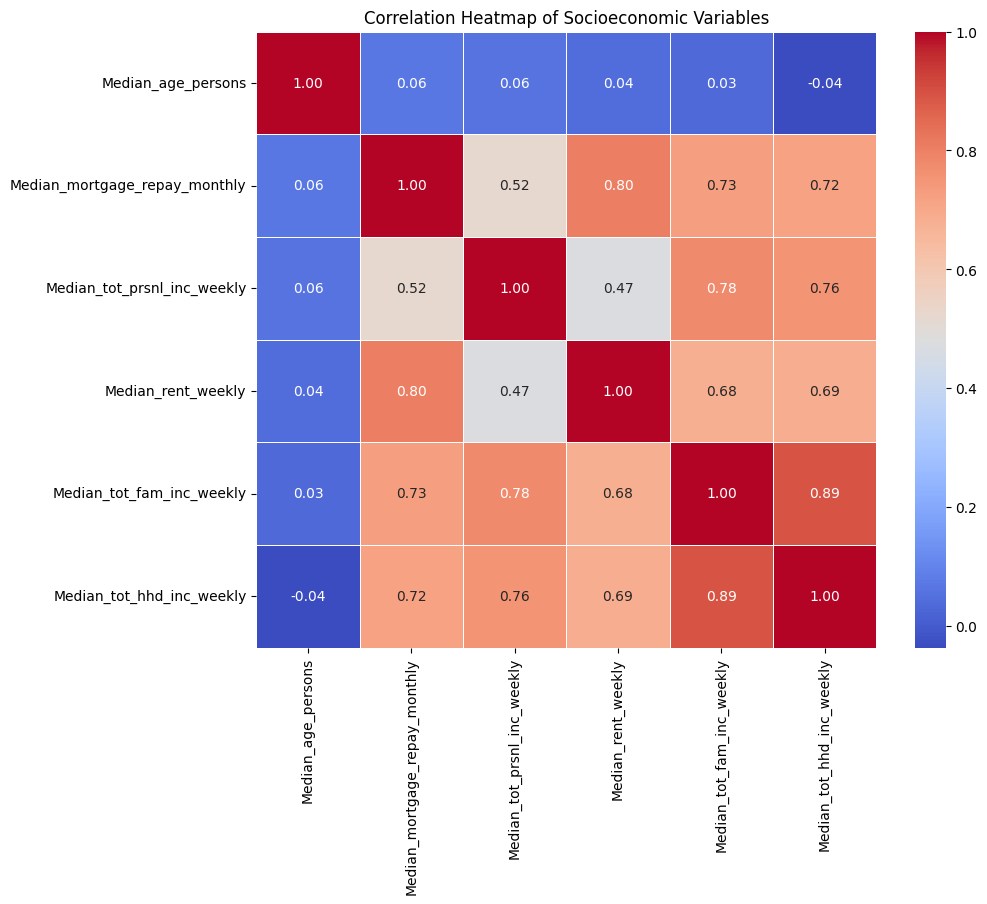

In [6]:
# Correlation matrix for income, age, mortgage repayment
correlation_data = g02[['Median_age_persons', 'Median_mortgage_repay_monthly', 
                        'Median_tot_prsnl_inc_weekly', 'Median_rent_weekly', 
                        'Median_tot_fam_inc_weekly', 'Median_tot_hhd_inc_weekly']]

# Compute correlation matrix
corr_matrix = correlation_data.corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title('Correlation Heatmap of Socioeconomic Variables')
plt.show()


#### Total Household Income (Weekly) by Household Composition - G33

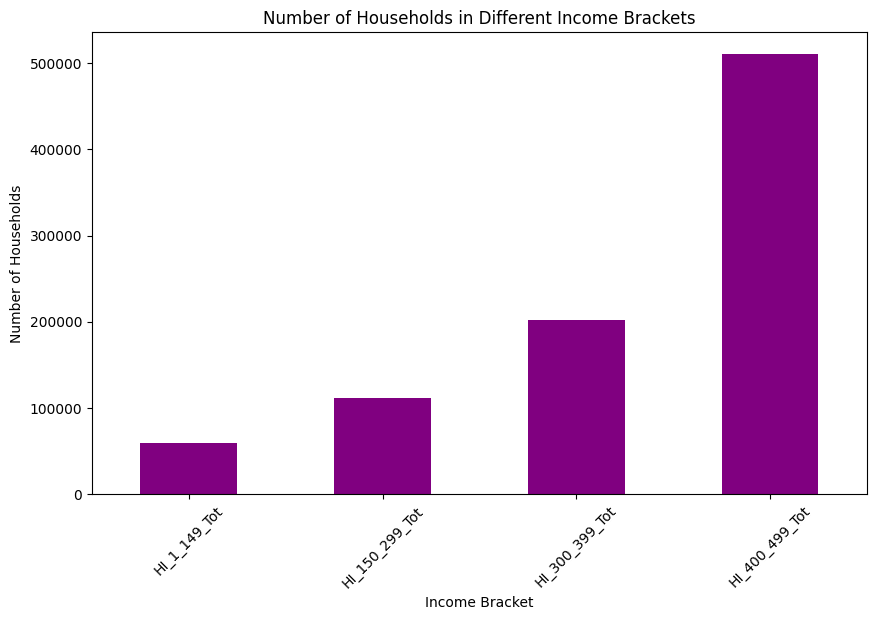

In [7]:
# Visualizing the number of households in different income brackets (for g33 dataset)
income_brackets = ['HI_1_149_Tot', 'HI_150_299_Tot', 'HI_300_399_Tot', 'HI_400_499_Tot']  # Example income brackets
income_data = g33[income_brackets].sum()

# Bar plot to visualize income categories
plt.figure(figsize=(10, 6))
income_data.plot(kind='bar', color='purple')
plt.title('Number of Households in Different Income Brackets')
plt.xlabel('Income Bracket')
plt.ylabel('Number of Households')
plt.xticks(rotation=45)
plt.show()


#### Number of Motor Vehicles by Dwellings - G34

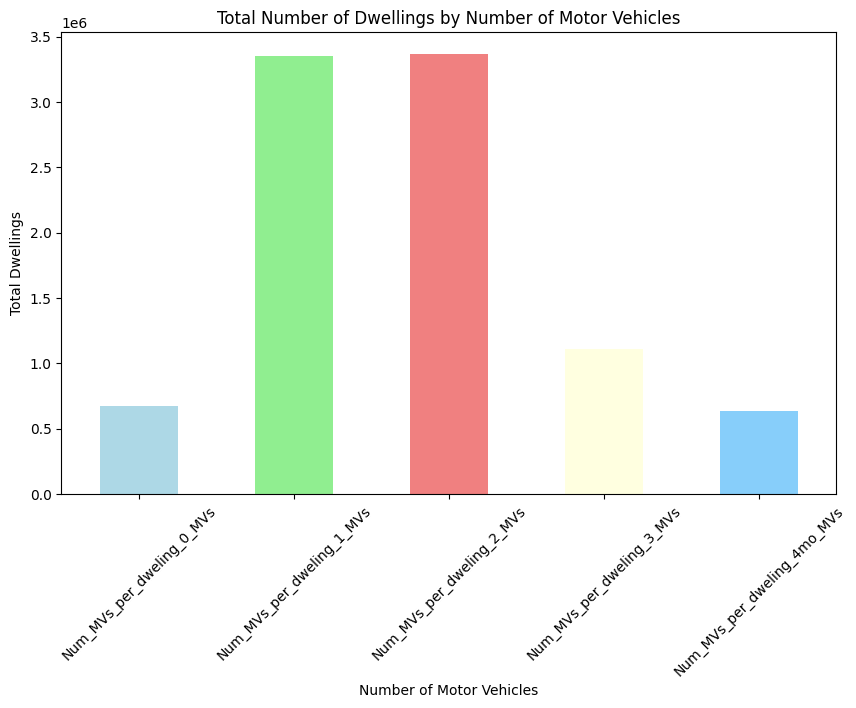

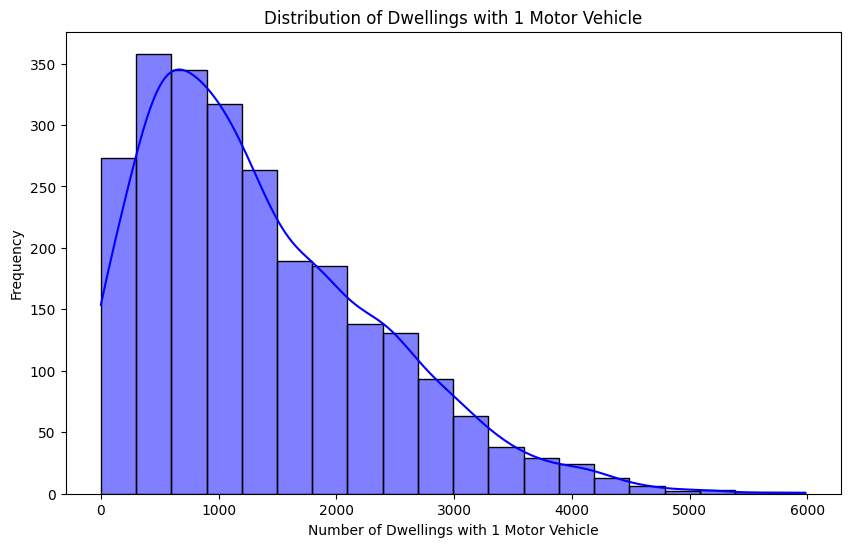

In [8]:
# 1. Plotting the distribution of dwellings based on the number of vehicles (using a stacked bar plot)
vehicle_columns = ['Num_MVs_per_dweling_0_MVs', 'Num_MVs_per_dweling_1_MVs', 
                   'Num_MVs_per_dweling_2_MVs', 'Num_MVs_per_dweling_3_MVs', 
                   'Num_MVs_per_dweling_4mo_MVs']

# Plotting the stacked bar plot for the number of motor vehicles per dwelling
vehicle_data = g34[vehicle_columns].sum()

plt.figure(figsize=(10, 6))
vehicle_data.plot(kind='bar', stacked=True, color=['lightblue', 'lightgreen', 'lightcoral', 'lightyellow', 'lightskyblue'])
plt.title('Total Number of Dwellings by Number of Motor Vehicles')
plt.xlabel('Number of Motor Vehicles')
plt.ylabel('Total Dwellings')
plt.xticks(rotation=45)
plt.show()

# 2. Plotting a histogram for one of the vehicle categories (e.g., Num_MVs_per_dweling_1_MVs)
plt.figure(figsize=(10, 6))
sns.histplot(g34['Num_MVs_per_dweling_1_MVs'], kde=True, color='blue', bins=20)
plt.title('Distribution of Dwellings with 1 Motor Vehicle')
plt.xlabel('Number of Dwellings with 1 Motor Vehicle')
plt.ylabel('Frequency')
plt.show()


In [9]:
# 1. Stacked bar plot for household composition (family vs non-family by number of persons)
household_size_columns = ['Num_Psns_UR_1_FamHhold', 'Num_Psns_UR_1_NonFamHhold', 
                          'Num_Psns_UR_2_FamHhold', 'Num_Psns_UR_2_NonFamHhold', 
                          'Num_Psns_UR_3_FamHhold', 'Num_Psns_UR_3_NonFamHhold']

# Summing up the family and non-family counts for each household size
household_data = pd.to_numeric(household_data, errors='coerce')

# Plotting a stacked bar plot
household_data.plot(kind='bar', stacked=True, figsize=(10, 6), color=['skyblue', 'orange'])
plt.title('Household Composition by Number of Persons (Family vs Non-Family)')
plt.xlabel('Household Size (Number of Persons)')
plt.ylabel('Total Households')
plt.xticks(rotation=45)
plt.legend(['Family Households', 'Non-Family Households'])
plt.show()

# 2. Line plot to visualize trends in the number of persons in family vs non-family households
plt.figure(figsize=(10, 6))
sns.lineplot(data=g35[['Num_Psns_UR_1_FamHhold', 'Num_Psns_UR_1_NonFamHhold']].sum(), marker='o')
plt.title('Trend of Household Composition (Family vs Non-Family)')
plt.xlabel('Number of Persons in Household')
plt.ylabel('Total Households')
plt.xticks(rotation=45)
plt.show()


NameError: name 'household_data' is not defined

In [ ]:
print(g35['Num_Psns_UR_1_FamHhold'])

In [ ]:

# Convert 'Num_Psns_UR_1_FamHhold' to numeric, coercing errors to NaN
g35['Num_Psns_UR_1_FamHhold'] = pd.to_numeric(g35['Num_Psns_UR_1_FamHhold'], errors='coerce')

# Check for any NaN values
print(g35['Num_Psns_UR_1_FamHhold'].isna().sum())

# Fill NaN values with 0 (or another strategy)
g35['Num_Psns_UR_1_FamHhold'] = g35['Num_Psns_UR_1_FamHhold'].fillna(0)

# Now, check the data types again to ensure the conversion worked
print(g35['Num_Psns_UR_1_FamHhold'].dtype)

# Check for any NaN values
print(g35['Num_Psns_UR_1_FamHhold'].isna().sum())

In [ ]:
# Summing up the family and non-family counts for each household size
# Ensure that all values in 'household_data' are numeric
household_data = pd.to_numeric(household_data, errors='coerce')

# Check if any values were converted to NaN
print(household_data.isna().sum())


# Check the summed data to ensure it's valid
print(household_data)

# Plotting a stacked bar plot
household_data.plot(kind='bar', stacked=True, figsize=(10, 6), color=['skyblue', 'orange'])
plt.title('Household Composition by Number of Persons (Family vs Non-Family)')
plt.xlabel('Household Size (Number of Persons)')
plt.ylabel('Total Households')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# 1. Stacked Bar Plot for mortgage repayment by dwelling structure (Separate House, Flat, etc.)
mortgage_columns = ['M_0_299_DS_Separate_hse', 'M_0_299_DS_Flat_apart', 'M_0_299_DS_Other_dwg', 
                    'M_300_449_DS_Separate_hse', 'M_300_449_DS_Flat_apart', 'M_300_449_DS_Other_dwg']

# Summing up the mortgage repayment data
mortgage_data = g38[mortgage_columns].sum()

# Plotting a stacked bar plot
mortgage_data.plot(kind='bar', stacked=True, figsize=(10, 6), color=['lightblue', 'lightgreen', 'lightcoral', 'lightyellow'])
plt.title('Mortgage Repayment Distribution by Dwelling Structure')
plt.xlabel('Mortgage Repayment Range')
plt.ylabel('Total Number of Dwellings')
plt.xticks(rotation=45)
plt.show()

# 2. Box plot for mortgage repayment spread across different dwelling types
plt.figure(figsize=(10, 6))
sns.boxplot(data=g38[['M_0_299_DS_Separate_hse', 'M_0_299_DS_Flat_apart', 'M_0_299_DS_Other_dwg']])
plt.title('Distribution of Mortgage Repayment by Dwelling Type')
plt.xlabel('Dwelling Type')
plt.ylabel('Mortgage Repayment')
plt.show()


## Variable Selection

In [10]:
# Select columns in g02
# removing medians of variables explained in other df
g02_filtered =  g02.drop(columns=['Median_mortgage_repay_monthly',
                                 'Median_tot_prsnl_inc_weekly', 
                                 'Median_tot_fam_inc_weekly', 
                                 'Median_tot_hhd_inc_weekly'])

g02_filtered.columns.tolist()

['SA2_CODE_2021',
 'Median_age_persons',
 'Median_rent_weekly',
 'Average_num_psns_per_bedroom',
 'Average_household_size']

In [11]:
# Select columns in g33
# Select columns that contain both "HI_" and "_Tot"
g33_col_mask = g33.columns[g33.columns.str.contains("HI_") & g33.columns.str.contains("_Tot")]

# Append the column name 'SA2_CODE_2021' to the list
g33_col_mask = g33_col_mask.insert(0, 'SA2_CODE_2021')

g33_filtered = g33[g33_col_mask]

g33_filtered.columns.tolist()

['SA2_CODE_2021',
 'HI_1_149_Tot',
 'HI_150_299_Tot',
 'HI_300_399_Tot',
 'HI_400_499_Tot',
 'HI_500_649_Tot',
 'HI_650_799_Tot',
 'HI_800_999_Tot',
 'HI_1000_1249_Tot',
 'HI_1250_1499_Tot',
 'HI_1500_1749_Tot',
 'HI_1750_1999_Tot',
 'HI_2000_2499_Tot',
 'HI_2500_2999_Tot',
 'HI_3000_3499_Tot',
 'HI_3500_3999_Tot',
 'HI_4000_more_Tot']

In [12]:
# Select columns in g34
# drop total and not stated households
g34_filtered = g34.drop(columns=['Num_MVs_per_dweling_Tot', 
                                 'Num_MVs_NS', 
                                 'Total_dwelings'])

g34_filtered.columns.tolist()

['SA2_CODE_2021',
 'Num_MVs_per_dweling_0_MVs',
 'Num_MVs_per_dweling_1_MVs',
 'Num_MVs_per_dweling_2_MVs',
 'Num_MVs_per_dweling_3_MVs',
 'Num_MVs_per_dweling_4mo_MVs']

In [13]:
# Select columns in g35
# Select columns that contain "_Total"
g35_col_mask = g35.columns[g35.columns.str.contains("_Total")]

# drop the last Total column
g35_col_mask = g35_col_mask.drop('Total_Total')

# Append the column name 'SA2_CODE_2021' to the list
g35_col_mask = g35_col_mask.insert(0, 'SA2_CODE_2021')

# Apply filtering mask
g35_filtered = g35[g35_col_mask]

g35_filtered.columns.tolist()

['SA2_CODE_2021',
 'Num_Psns_UR_1_Total',
 'Num_Psns_UR_2_Total',
 'Num_Psns_UR_3_Total',
 'Num_Psns_UR_4_Total',
 'Num_Psns_UR_5_Total',
 'Num_Psns_UR_6mo_Total']

In [14]:
# Select columns in g38
# Select columns that contain both "M_" and "_Tot"
g38_col_mask = g38.columns[g38.columns.str.contains("M_") & g38.columns.str.contains("_Tot")]

# Append the column name 'SA2_CODE_2021' to the list
g38_col_mask = g38_col_mask.insert(0, 'SA2_CODE_2021')

# Apply filtering mask
g38_filtered = g38[g38_col_mask]

g38_filtered.columns.tolist()

['SA2_CODE_2021',
 'M_0_299_Tot',
 'M_300_449_Tot',
 'M_450_599_Tot',
 'M_600_799_Tot',
 'M_800_999_Tot',
 'M_1000_1399_Tot',
 'M_1400_1799_Tot',
 'M_1800_2399_Tot',
 'M_2400_2999_Tot',
 'M_3000_3999_Tot',
 'M_4000_over_Tot']

### Joining dataframes

In [15]:
def merge_dataframes(dataframes, common_column):
    # Start with the first DataFrame
    merged_df = dataframes[0]

    # Iteratively merge the remaining DataFrames
    for df in dataframes[1:]:
        merged_df = merged_df.merge(df, on=common_column, how='inner')

    return merged_df

# Merging filtered df
census_joined = merge_dataframes([g02_filtered, g33_filtered, g34_filtered, g35_filtered, g38_filtered], 'SA2_CODE_2021')
census_joined.shape

(2472, 43)

### Final data EDA

In [16]:
census_joined.dtypes

SA2_CODE_2021                     int64
Median_age_persons                int64
Median_rent_weekly                int64
Average_num_psns_per_bedroom    float64
Average_household_size          float64
HI_1_149_Tot                      int64
HI_150_299_Tot                    int64
HI_300_399_Tot                    int64
HI_400_499_Tot                    int64
HI_500_649_Tot                    int64
HI_650_799_Tot                    int64
HI_800_999_Tot                    int64
HI_1000_1249_Tot                  int64
HI_1250_1499_Tot                  int64
HI_1500_1749_Tot                  int64
HI_1750_1999_Tot                  int64
HI_2000_2499_Tot                  int64
HI_2500_2999_Tot                  int64
HI_3000_3499_Tot                  int64
HI_3500_3999_Tot                  int64
HI_4000_more_Tot                  int64
Num_MVs_per_dweling_0_MVs         int64
Num_MVs_per_dweling_1_MVs         int64
Num_MVs_per_dweling_2_MVs         int64
Num_MVs_per_dweling_3_MVs         int64


In [17]:
census_joined.isna().sum()

SA2_CODE_2021                   0
Median_age_persons              0
Median_rent_weekly              0
Average_num_psns_per_bedroom    0
Average_household_size          0
HI_1_149_Tot                    0
HI_150_299_Tot                  0
HI_300_399_Tot                  0
HI_400_499_Tot                  0
HI_500_649_Tot                  0
HI_650_799_Tot                  0
HI_800_999_Tot                  0
HI_1000_1249_Tot                0
HI_1250_1499_Tot                0
HI_1500_1749_Tot                0
HI_1750_1999_Tot                0
HI_2000_2499_Tot                0
HI_2500_2999_Tot                0
HI_3000_3499_Tot                0
HI_3500_3999_Tot                0
HI_4000_more_Tot                0
Num_MVs_per_dweling_0_MVs       0
Num_MVs_per_dweling_1_MVs       0
Num_MVs_per_dweling_2_MVs       0
Num_MVs_per_dweling_3_MVs       0
Num_MVs_per_dweling_4mo_MVs     0
Num_Psns_UR_1_Total             0
Num_Psns_UR_2_Total             0
Num_Psns_UR_3_Total             0
Num_Psns_UR_4_

## Modelling

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#!pip install xgboost
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
#import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time
from sklearn.model_selection import GridSearchCV

In [19]:
# Prepare features and target
def prepare_features(df, target):
    features = df.columns.drop(target)
    X = df[features]
    y = df[target]
    return X, y

In [20]:
X, y = prepare_features(census_joined, 'HI_3500_3999_Tot')
X.columns

Index(['SA2_CODE_2021', 'Median_age_persons', 'Median_rent_weekly',
       'Average_num_psns_per_bedroom', 'Average_household_size',
       'HI_1_149_Tot', 'HI_150_299_Tot', 'HI_300_399_Tot', 'HI_400_499_Tot',
       'HI_500_649_Tot', 'HI_650_799_Tot', 'HI_800_999_Tot',
       'HI_1000_1249_Tot', 'HI_1250_1499_Tot', 'HI_1500_1749_Tot',
       'HI_1750_1999_Tot', 'HI_2000_2499_Tot', 'HI_2500_2999_Tot',
       'HI_3000_3499_Tot', 'HI_4000_more_Tot', 'Num_MVs_per_dweling_0_MVs',
       'Num_MVs_per_dweling_1_MVs', 'Num_MVs_per_dweling_2_MVs',
       'Num_MVs_per_dweling_3_MVs', 'Num_MVs_per_dweling_4mo_MVs',
       'Num_Psns_UR_1_Total', 'Num_Psns_UR_2_Total', 'Num_Psns_UR_3_Total',
       'Num_Psns_UR_4_Total', 'Num_Psns_UR_5_Total', 'Num_Psns_UR_6mo_Total',
       'M_0_299_Tot', 'M_300_449_Tot', 'M_450_599_Tot', 'M_600_799_Tot',
       'M_800_999_Tot', 'M_1000_1399_Tot', 'M_1400_1799_Tot',
       'M_1800_2399_Tot', 'M_2400_2999_Tot', 'M_3000_3999_Tot',
       'M_4000_over_Tot'],
      d

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training data shape:", X_train.shape, "\n" + "Validation data shape:", X_test.shape)

Training data shape: (1977, 42) 
Validation data shape: (495, 42)


In [22]:
def create_and_evaluate_pipeline(X_train, X_test, y_train, y_test, regressor):
    # Create the pipeline with the specified regressor
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Standardizing the data
        ('regressor', regressor)        # The regressor passed as an argument
    ])

    # Start the timer
    start_time = time.time()

    # Fit the model
    pipeline.fit(X_train, y_train)

    # Stop the timer
    end_time = time.time()
    elapsed_time = end_time - start_time

    # Make predictions
    y_pred = pipeline.predict(X_test)

    # Evaluate the model
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Display evaluation metrics
    print(f"Regressor: {regressor.__class__.__name__}")
    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R² Score: {r2:.2f}")
    print(f"Time elapsed: {elapsed_time:.2f} seconds")

### Open-Sourced modelling packages

In [23]:
# To use the function with different regressors:
create_and_evaluate_pipeline(X_train, X_test, y_train, y_test, 
                             RandomForestRegressor(n_estimators=100, random_state=42))
create_and_evaluate_pipeline(X_train, X_test, y_train, y_test, 
                             GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42))
create_and_evaluate_pipeline(X_train, X_test, y_train, y_test, 
                             ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42))
create_and_evaluate_pipeline(X_train, X_test, y_train, y_test, 
                             SVR(kernel='poly', C=1.0, epsilon=0.1))
create_and_evaluate_pipeline(X_train, X_test, y_train, y_test, 
                             XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42))

Regressor: RandomForestRegressor
Mean Absolute Error: 13.13
Mean Squared Error: 345.63
R² Score: 0.97
Time elapsed: 3.95 seconds
Regressor: GradientBoostingRegressor
Mean Absolute Error: 12.76
Mean Squared Error: 300.36
R² Score: 0.97
Time elapsed: 1.49 seconds
Regressor: ElasticNet
Mean Absolute Error: 19.05
Mean Squared Error: 672.68
R² Score: 0.94
Time elapsed: 0.01 seconds
Regressor: SVR
Mean Absolute Error: 50.23
Mean Squared Error: 4144.23
R² Score: 0.65
Time elapsed: 0.18 seconds
Regressor: XGBRegressor
Mean Absolute Error: 12.60
Mean Squared Error: 299.32
R² Score: 0.97
Time elapsed: 0.19 seconds


### SAS ML models

SAS has released a proprietary Python package named sasviya.ml that contains optimized SAS machine learning algorithms designed to run in SAS Viya Workbench.

https://go.documentation.sas.com/doc/en/workbenchcdc/v_001/explore/titlepage.htm

In [24]:
#fit a random forest model
from sasviya.ml.tree import ForestRegressor as sas_ForestRegressor
from sasviya.ml.tree import GradientBoostingRegressor as sas_GradientBoostingRegressor
from sasviya.ml.linear_model import ElasticNet as sas_ElasticNet
from sasviya.ml.svm import SVR as sas_SVR
from sasviya.ml.decomposition import PCA as sas_PCA

In [25]:
create_and_evaluate_pipeline(X_train, X_test, y_train, y_test, 
                             sas_ForestRegressor(n_estimators=100, random_state=42))
create_and_evaluate_pipeline(X_train, X_test, y_train, y_test, 
                             sas_GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42))
create_and_evaluate_pipeline(X_train, X_test, y_train, y_test, 
                             sas_ElasticNet(alpha=1.0, l1_ratio=0.5)) # no random_state parameter
create_and_evaluate_pipeline(X_train, X_test, y_train, y_test, 
                             sas_SVR(kernel='poly', C=1.0, epsilon=0.1))

Regressor: ForestRegressor
Mean Absolute Error: 14.57
Mean Squared Error: 445.34
R² Score: 0.96
Time elapsed: 0.76 seconds
Regressor: GradientBoostingRegressor
Mean Absolute Error: 13.02
Mean Squared Error: 321.14
R² Score: 0.97
Time elapsed: 0.24 seconds
Regressor: ElasticNet
Mean Absolute Error: 19.05
Mean Squared Error: 672.80
R² Score: 0.94
Time elapsed: 0.07 seconds
Regressor: SVR
Mean Absolute Error: 12.00
Mean Squared Error: 277.77
R² Score: 0.98
Time elapsed: 0.72 seconds


## Model Tuning

In [26]:
## Open source champion tuning
# Define the model
xgb = XGBRegressor(random_state=42)

# Set up the parameter grid
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__max_depth': [3, 4, 5],
    'regressor__subsample': [0.8, 1.0],
    'regressor__colsample_bytree': [0.8, 1.0]
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', xgb)
    ]),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1  # Use all available cores
)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Display the best parameters and best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score (neg MSE): {grid_search.best_score_}")

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best parameters: {'regressor__colsample_bytree': 0.8, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 4, 'regressor__n_estimators': 200, 'regressor__subsample': 0.8}
Best cross-validation score (neg MSE): -287.39649149593185


In [27]:
create_and_evaluate_pipeline(X_train, X_test, y_train, y_test, 
                             grid_search.best_estimator_)

Regressor: Pipeline
Mean Absolute Error: 12.53
Mean Squared Error: 298.87
R² Score: 0.97
Time elapsed: 0.44 seconds


In [28]:
## SAS champion model tuning
# Specify the number of principal components to keep
n_components = 20

# using PCA to for feature selection
pca = sas_PCA(n_components=n_components, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

pca.describe()

[Key]

               Store Key                
 
                                      Key
 490AF72C943FC0DF1C792B0C6B26251D3A8C7D88

[Description]

        Basic Information         
 
       Attribute              Value
 Analytic Engine                pca
    Time Created 28Nov2024:05:09:42

[InputVariables]

                           Input Variables                            
 
                         Name  Length  Role     Type RawType FormatName
                SA2_CODE_2021     8.0 Input Interval     Num           
           Median_age_persons     8.0 Input Interval     Num           
           Median_rent_weekly     8.0 Input Interval     Num           
 Average_num_psns_per_bedroom     8.0 Input Interval     Num           
       Average_household_size     8.0 Input Interval     Num           
                 HI_1_149_Tot     8.0 Input Interval     Num           
               HI_150_299_Tot     8.0 Input Interval     Num           
               HI_300_399_Tot     8.0 Input Interval     Num           
               HI_400_499_Tot     8.0 Input Interval     Num           
               HI_500_649_Tot     8.0 Input Interval     Num           
               HI_650_799_Tot     8.0 Input Interval     Num           
               HI_800_999_Tot     8.0 Input Interval     Num           
             HI_1000_1249_Tot     8.0 Input Interval     Num           
             HI_1250_1499_Tot     8.0 Input Interval     Num           
             HI_1500_1749_Tot     8.0 Input Interval     Num           
             HI_1750_1999_Tot     8.0 Input Interval     Num           
             HI_2000_2499_Tot     8.0 Input Interval     Num           
             HI_2500_2999_Tot     8.0 Input Interval     Num           
             HI_3000_3499_Tot     8.0 Input Interval     Num           
             HI_4000_more_Tot     8.0 Input Interval     Num           
    Num_MVs_per_dweling_0_MVs     8.0 Input Interval     Num           
    Num_MVs_per_dweling_1_MVs     8.0 Input Interval     Num           
    Num_MVs_per_dweling_2_MVs     8.0 Input Interval     Num           
    Num_MVs_per_dweling_3_MVs     8.0 Input Interval     Num           
  Num_MVs_per_dweling_4mo_MVs     8.0 Input Interval     Num           
          Num_Psns_UR_1_Total     8.0 Input Interval     Num           
          Num_Psns_UR_2_Total     8.0 Input Interval     Num           
          Num_Psns_UR_3_Total     8.0 Input Interval     Num           
          Num_Psns_UR_4_Total     8.0 Input Interval     Num           
          Num_Psns_UR_5_Total     8.0 Input Interval     Num           
        Num_Psns_UR_6mo_Total     8.0 Input Interval     Num           
                  M_0_299_Tot     8.0 Input Interval     Num           
                M_300_449_Tot     8.0 Input Interval     Num           
                M_450_599_Tot     8.0 Input Interval     Num           
                M_600_799_Tot     8.0 Input Interval     Num           
                M_800_999_Tot     8.0 Input Interval     Num           
              M_1000_1399_Tot     8.0 Input Interval     Num           
              M_1400_1799_Tot     8.0 Input Interval     Num           
              M_1800_2399_Tot     8.0 Input Interval     Num           
              M_2400_2999_Tot     8.0 Input Interval     Num           
              M_3000_3999_Tot     8.0 Input Interval     Num           
              M_4000_over_Tot     8.0 Input Interval     Num           

[OutputVariables]

    Output Variables     
 
   Name  Length Type Label
  Prin1     8.0  Num      
  Prin2     8.0  Num      
  Prin3     8.0  Num      
  Prin4     8.0  Num      
  Prin5     8.0  Num      
  Prin6     8.0  Num      
  Prin7     8.0  Num      
  Prin8     8.0  Num      
  Prin9     8.0  Num      
 Prin10     8.0  Num      
 Prin11     8.0  Num      
 Prin12     8.0  Num      
 Prin13     8.0  Num      
 Prin14     8.0  Num      
 Prin15     8.0  Num      
 Prin16     8.0  Num      
 Prin17   

In [29]:
# Define the SVR model
sas_svr = sas_SVR(kernel='poly', random_state=42)

# Set up the parameter grid
param_grid = {
    'regressor__C': [0.1, 1.0, 10.0],
    'regressor__epsilon': [0.01, 0.1, 0.2],
    'regressor__degree': [2, 3, 4],  # Only relevant for polynomial kernel
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', sas_svr)
    ]),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1  # Use all available cores
)

# Fit the grid search
grid_search.fit(X_train_pca, y_train) # using features from PCA

# Display the best parameters and best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score (neg MSE): {grid_search.best_score_}")

Fitting 3 folds for each of 27 candidates, totalling 81 fits


/usr/local/lib64/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
27 fits failed out of a total of 81.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib64/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib64/python3.11/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib64/python3.11/site-packages/sklearn/pipeline.py", line 420, in fit
    self._final_estimator.fit(Xt,

Best parameters: {'regressor__C': 10.0, 'regressor__degree': 2, 'regressor__epsilon': 0.01}
Best cross-validation score (neg MSE): -426.48878364473507


In [30]:
create_and_evaluate_pipeline(X_train_pca, X_test_pca, y_train, y_test, 
                             grid_search.best_estimator_)

Regressor: Pipeline
Mean Absolute Error: 12.57
Mean Squared Error: 286.90
R² Score: 0.98
Time elapsed: 0.18 seconds


In [31]:
# Define the SVR model
sas_svr = sas_SVR(kernel='poly', random_state=42)

# Set up the parameter grid
param_grid = {
    'regressor__C': [0.1, 1.0, 10.0],
    'regressor__epsilon': [0.01, 0.1, 0.2],
    'regressor__degree': [2, 3, 4],  # Only relevant for polynomial kernel
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', sas_svr)
    ]),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1  # Use all available cores
)

# Fit the grid search
grid_search.fit(X_train, y_train) # using not selected features

# Display the best parameters and best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score (neg MSE): {grid_search.best_score_}")

Fitting 3 folds for each of 27 candidates, totalling 81 fits


2024-11-28 05:10:12,931 [ERROR   ] [151 ][_action.py     ] The total feature dimension (42) is high for polynomial degree 3.
2024-11-28 05:10:12,931 [ERROR   ] [151 ][_action.py     ] The dimension is too high to process.
2024-11-28 05:10:12,976 [ERROR   ] [151 ][_action.py     ] The total feature dimension (42) is high for polynomial degree 3.
2024-11-28 05:10:12,977 [ERROR   ] [151 ][_action.py     ] The dimension is too high to process.
2024-11-28 05:10:13,060 [ERROR   ] [151 ][_action.py     ] The total feature dimension (42) is high for polynomial degree 3.
2024-11-28 05:10:13,060 [ERROR   ] [151 ][_action.py     ] The dimension is too high to process.
2024-11-28 05:10:13,070 [ERROR   ] [151 ][_action.py     ] The total feature dimension (42) is high for polynomial degree 3.
2024-11-28 05:10:13,071 [ERROR   ] [151 ][_action.py     ] The dimension is too high to process.
2024-11-28 05:10:13,091 [ERROR   ] [151 ][_action.py     ] The total feature dimension (42) is high for polynomi

Best parameters: {'regressor__C': 0.1, 'regressor__degree': 2, 'regressor__epsilon': 0.01}
Best cross-validation score (neg MSE): -320.76405625380147


In [32]:
create_and_evaluate_pipeline(X_train, X_test, y_train, y_test, 
                             grid_search.best_estimator_)

Regressor: Pipeline
Mean Absolute Error: 12.29
Mean Squared Error: 275.26
R² Score: 0.98
Time elapsed: 0.64 seconds


Best model is the SAS SVR model before PCA. Model tuning slightly reduced the MSE and sped up compute time, but MAE increased and no imporvement to R^2.

Might see if SAS's GB model can have better performance post-tuning.

## Model Deployment

Push the model back to Viya platform for deployment and goverance thereafter.

In [33]:
name = "tztsai"

In [41]:
# best performing model
regressor = sas_SVR(kernel='poly', C=1.0, epsilon=0.1)

# Create the pipeline with the specified regressor
wb_model = Pipeline([
    ('scaler', StandardScaler()),  # Standardizing the data
    ('regressor', regressor)        # The regressor passed as an argument
])
# Fit the model
wb_model.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', SVR(kernel="poly", epsilon=0.1))])

In [49]:
wb_model = sas_SVR(kernel='poly', C=1.0, epsilon=0.1)
# Fit the model
wb_model.fit(X_train, y_train)

SVR(kernel="poly", epsilon=0.1)

In [35]:
## get access token for viya env using refresh token. change to your own viya server and preferred authentication method.
url = "https://apgtps2demo.gtp.unx.sas.com"
auth_url = f"{url}/SASLogon/oauth/token"
## reading long-lived refresh token from txt file
refresh_token = Path(f'/workspaces/{os.environ["DEFAULT_MOUNTNAME"]}/Census_Project/apgtps2demo_refresh_token.txt').read_text().replace('\n', '')

payload=f'grant_type=refresh_token&refresh_token={refresh_token}'
headers = {
  'Accept': 'application/json',
  'Content-Type': 'application/x-www-form-urlencoded',
  'Authorization': 'Basic c2FzLmNsaTo=',
}

response = requests.request("POST", auth_url, headers=headers, data=payload, verify=False)
access_token = response.json()['access_token']

/usr/local/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'apgtps2demo.gtp.unx.sas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [36]:
st = Session("https://apgtps2demo.gtp.unx.sas.com", token=access_token, verify_ssl=False)
st

In [37]:
project_name = "CBR WorkshopWorkbench HandsOn "+name

In [45]:
## Create a project
try:
    repository = mr.get_repository('DMRepository')
    # repository.name
    project_create = mr.create_project(
        {
        'name':project_name,
        'description':'CBR WB Hands-on Exercise',
        'function':'classification',
        'targetLevel':'binary',
        },
        repository
    )
    print("Created a new project!")
    project = mr.get_project(project_name)
except:
    print("Retrieving already created project")
    project = mr.get_project(project_name)

Created a new project!


In [39]:
def register_model(model_name, model, project):
    model_params = {
        "name": model_name,
        "projectId": project.id,
        "type": "ASTORE",
    }
    astore = mr.post(
        "/models",
        files={"files": (f"{model_name}.astore", model.export())},
        data=model_params,
    )
    print(astore)

In [51]:
# Model Registration
register_model("MyModel "+name, wb_model, project) #This is only pure sas model, find out how to register .pkl files

MyModel tztsai
